In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 10) # set default figure size, 8in by 6in

In this module, we introduce Principal Components Analysis, and show how it can be used for data compression to speed up learning algorithms as well as for visualizations of complex datasets.

# Video W8 06: Motivation I Data Compression

[YouTube Video Link](https://www.youtube.com/watch?v=h8ri2gbBjIc&index=82&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)

This video gives a good intuitive idea of how data compression by reducing dimensions works.  As shown in the video, a 2
dimensional highly redundante (linear) feature can be basically reduced to 1 dimension with almost no loss of information.
This type of reduction of dimensions is very important in practice.  Less dimensions means less features we have for our learning
algorithms.  This reduces the time and effort needed to build models using the features.  


# Video W8 07: Motivation II Data Visualization

[YouTube Video Link](https://www.youtube.com/watch?v=18xeFJZAdMw&index=83&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)


Another main use of dimensionality reduction is in order to visualize very high dimensional data in 2 or 3 dimensional space and
plots.

# Video W8 08: Principal Component Analysis

[YouTube Video Link](https://www.youtube.com/watch?v=aSl7tPE1Pyo&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=84)


The formal method for accomplishing dimensionality reduction through the technique known as Principle Component Analysis (PCA) has
some surface similarity to performing a linear regression.  Intuitively, we are trying to find a lower dimensional hyperplane for our data
to which when we project our original data we minimize the sum squared error of the distances we had to project the data in order
to reduce the dimensionality (the projection error).

Principal Component Analysis (PCA) attempts to find a projection to a lower dimensional hyperplane
that  minimizes the sum squared projection error of the projection of the points onto the new lower 
dimensional hyperplane.  As shown in the example in the video, if our original data is 
$\mathbb{R}^2$ (2 dimensional), the lower dimensional hyperplane is in this case a 1 dimensional line.

Lets look at a quick example of using PCA.  The following example is taken directly from the
`scikit-learn` library [example on using PCA](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html).

First of all, lets look at a rather famous data set, the Iris dataset.  This data set consists of
only $m = 150$ data points.  The data points are labeled between 3 different species of Iris
flowers (species Virginica, Versicolor and Setosa).  PCA is an unsupervised learning technique, so
we don't need the labels.  Each of the 150 data points has $\mathbb{R}^4$ 4 dimensional measurements associated with it (petal length and width, and sepal length and width).  We of course can't visualze
all 4 dimensions simultaneously, so lets visualize 3 of the 4 data points:  

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

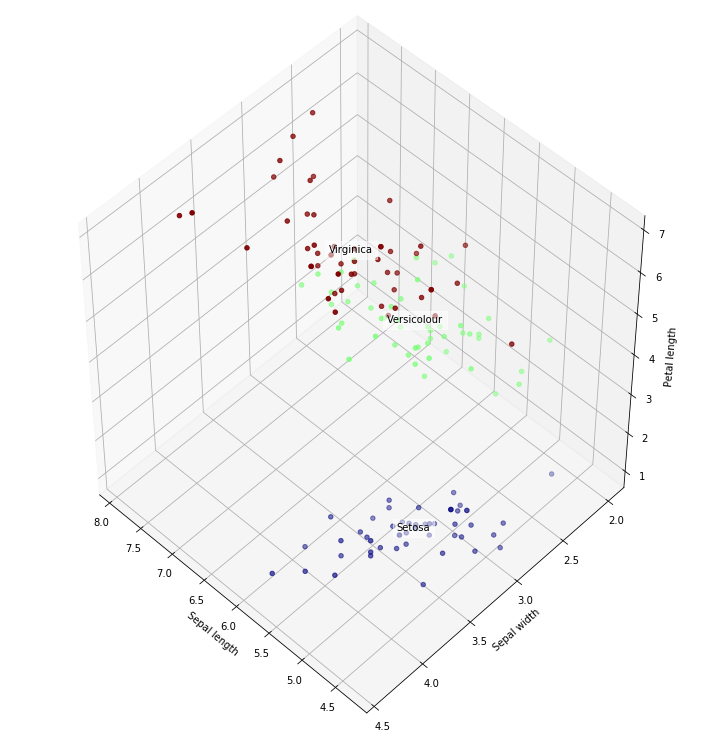

In [3]:
# plot 3 of the 4 dimnsions
fig = plt.figure()
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.jet)

# The data in the 4 dimensions are:
# X[:, 0] = 'sepal length'
# X[:, 1] = 'sepal width'
# X[:, 2] = 'petal length'
# X[:, 3] = 'petal width'
# so if you want the labels on the axis to be correct if you plot different
# dimensions, need to also change these labels.
dims = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width']
ax.xaxis.set_label_text(dims[0])
ax.yaxis.set_label_text(dims[1])
ax.zaxis.set_label_text(dims[2])

# likewise, we are labeling the type of each of the 3 species clases
# by putting a text label on the feature at the mean.  You would have to
# change the code here ias well to specify which dimensions of X[,?] you are plotting
for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean(),
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))


I encourage you to try plotting some other combinations of dimensions.  Also, unfortunately, there is no
easy way to rotate the 3D image for viewing interactively in an iPython notebook.  You can change the
elevation and azimus when we create the 3D axis object to view the data from different angles.

Lets compress the data from 4 dimensions to its 2 principal component dimensions and see the result.

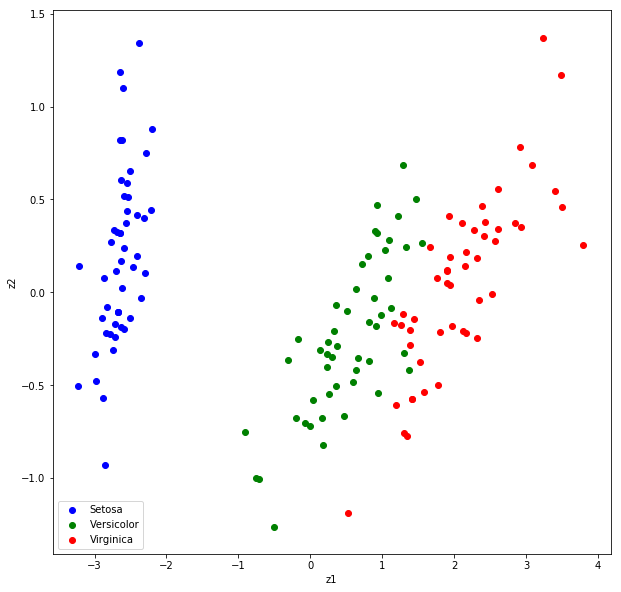

In [4]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

plt.figure()
plt.scatter(X[y==0, 0], X[y==0, 1], c='b', label='Setosa')
plt.scatter(X[y==1, 0], X[y==1, 1], c='g', label='Versicolor')
plt.scatter(X[y==2, 0], X[y==2, 1], c='r', label='Virginica')

plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()

In [5]:
print(pca.explained_variance_ratio_)
print(pca.mean_)

[ 0.92461621  0.05301557]
[ 5.84333333  3.054       3.75866667  1.19866667]


So if PCA is working correctly, this represents the 2 dimensions from the original 4 with the least amount of projection error of the original 4 dimensional data.  As you can see, while Setosa is well separated
from the other 2 classes, there is some overlaop in Versicolor and Virginica classes.  

# Video W8 09: Principal Component Analysis Algorithm

[YouTube Video Link](https://www.youtube.com/watch?v=G7HJWzjQNSQ&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=85)

This video starts out by noting that you should always perform mean feature scaling and mean normalization
of the features.  You will notice that in the example I gave above I did not do this by hand.  This is
because the `scikit-learn` PCA library automatically performs the normalization on the
data you give it before running PCA.  You will notice, for example, that the 2 dimensional principal
components are centered at the origin $0, 0$


The video at this point goes into the details of how the PCA algorithm is computed.  As stated in the
video, we won't look at any proofs that these procedures correctly comptue the hyperplanes that
minimize the projection error (it is beyond the scope of our course).  But lets just compute
the PCA by hand using Python functions, and compare our results to the PCA computation obtained
through the `scikit-learn` library.  

As in the previous example, lets continue using the iris data set with 4 dimensions to perform
our example of computing the PCA algorithm:

In [6]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

m, n = X.shape # m training examples, each n dimensional
print(m, "training examples")
print(n, "features/dimensions")

150 training examples
4 features/dimensions


Before when we used PCA from the `scikit-learn` library, it perform feature normalization for us.  But
if we want to do PCA ourself by hand, we need to perform normalization:

$$
\mu_j = \frac{1}{m} \sum_{i=1}^{m} x_j^{(i)}
$$

Where the $\mu_j$ is really the mean for each of the $n$ features of our data.  We replace each
feature $x_j^{(i)}$ with $x_j - \mu_j$ (e.g. we are simply subtracting the mean from each feature).
We can do feature normalization by hand like this:


In [7]:
# we could use loops to calculate the mean of each of the 4 features, but we can
# use a simply numpy operation to get the mean along the appropriate axis
mu = np.mean(X, axis=0)

# we should end up with the mean value of each of our 4 dimensions, compare this to the means
# in the iris dataset documentation to verify
print(mu.shape)
print(mu)

(4,)
[ 5.84333333  3.054       3.75866667  1.19866667]


Once we have the means of each dimension, we can perform mean normalization.  Again we'll use numpy
operations to subtract the mean for each dimension from each data set item

In [8]:
X_norm = X - mu
print(X_norm.shape)

 # notice that the means are all now basically 0 in our mean normalized data
print(np.mean(X_norm, axis=0))

(150, 4)
[ -1.12502600e-15  -6.75015599e-16  -3.23889064e-15  -6.06921920e-16]


To also do the feature scaling, one simple way is to calculate the standard deviation of each of 
our dimensions in the data, then divide the values by this standard deviation.  This has the effect of
scaling the standard deviation of the dimension to be 1.0.  For example, we can do a very similar 
procedure to calculate the sd of each dimension, the perform both normalization and scaling

$$
X_j^{(i)} \leftarrow \frac{X_j^{(i)} - \mu_j}{s_j}
$$

In [9]:
sd =  np.std(X, axis=0)

# we should end up with the standard deviation value of each of our 4 dimensions, again you
# can compare this to the reported sd for each dimension
print(sd.shape)
print(sd)

(4,)
[ 0.82530129  0.43214658  1.75852918  0.76061262]


In [10]:
X_norm_scaled = (X - mu) / sd
print(X_norm_scaled.shape)

 # notice that the means are all now basically 0 in our mean normalized data
print(np.mean(X_norm_scaled, axis=0))
print(np.std(X_norm_scaled, axis=0))

(150, 4)
[ -1.69031455e-15  -1.63702385e-15  -1.48251781e-15  -1.62314606e-15]
[ 1.  1.  1.  1.]


So as shown, the final result of normalization and scaling is that all features now have a mean of 0 and
a standard deviation of 1.0.  It appears that the `scikit-learn` PCA only performs mean normalization 
for you on the data you fit.  Thus, in the above cells I created arrays `X_norm` and `X_nrom_scaled`,
but we will only use `X_norm` in the next cells when we recreate the PCA algorithm by hand.

The first step shown in the video to perform the **PCA algorithm** is to compute a "covariance
matrix", that we will name `Sigma`.  The formula for computing the covariance matrix is:

$$
\Sigma = \frac{1}{m} \sum_{i=1}^{m} (x^{(i)}) (x^{(i)})^T
$$

**NOTE**: There is a typo first time this equation is shown in video around time 8:00.  The sum goes over 
the $m$ training input patterns.

We can compute that using Python for a single dimension, like dimension 0, with the following code:

In [11]:
# In python, our dimensions are 0, 1, 2 and 3, so the above formula sums from i = 0 to 3.
# For example, if we start with dimension 0, and we multiple x^(0) x^(0)^T we get
c = np.dot(X_norm[0, :].reshape( (n,1) ), X_norm[0, :].reshape( (n,1) ).T)
print(c.shape)
print(c)

(4, 4)
[[ 0.55254444 -0.33152667  1.75327556  0.74234222]
 [-0.33152667  0.198916   -1.05196533 -0.44540533]
 [ 1.75327556 -1.05196533  5.56330844  2.35552178]
 [ 0.74234222 -0.44540533  2.35552178  0.99733511]]


The result of doing this for dimension 0 is a 4 x 4 covariance matrix for that dimension.  This basically measures the amount of variance between each dimension for input pattern 0.  To get the full covariance
matrix, we need to do this for all 150 input patterns, and sum up and average the result

In [12]:
Sigma = np.empty( (n, n) )
for i in range(m):
    Sigma += np.dot( X_norm[i,:].reshape( (n, 1) ), X_norm[i, :].reshape(n, 1).T )
Sigma = Sigma / m # finally take average by dividing by m

print(Sigma.shape)
print(Sigma)

(4, 4)
[[ 0.68112222 -0.03900667  1.26519111  0.51345778]
 [-0.03900667  0.18675067 -0.319568   -0.11719467]
 [ 1.26519111 -0.319568    3.09242489  1.28774489]
 [ 0.51345778 -0.11719467  1.28774489  0.57853156]]


In [13]:
# as shown later in the video, an equivalent way of computing
# sigma using linear algebra matrix multiplication exclusively is
Sigma = (1.0 / m) * np.dot(X_norm.T, X_norm)
print(Sigma.shape)
print(Sigma)

(4, 4)
[[ 0.68112222 -0.03900667  1.26519111  0.51345778]
 [-0.03900667  0.18675067 -0.319568   -0.11719467]
 [ 1.26519111 -0.319568    3.09242489  1.28774489]
 [ 0.51345778 -0.11719467  1.28774489  0.57853156]]


Once we have the `Sigma` covariance matrix, the next step shown was to calculated the "eigenvectors"
of the matrix.  We will also use the singular value decomposition of the matrix from the numpy
linalg library to do this computation.


In [14]:
U, S, V = np.linalg.svd(Sigma)
print(U.shape)
print(S.shape)
print(V.shape)

(4, 4)
(4,)
(4, 4)


If you look at the U matrix, these are the $u$ vectors that define the PCA space, and if we want only
the first $k$ dimensions, we take the first $k$ vectors of the U matrix

In [15]:
print(U)
# if we wanted only 2 dimensions, we could take the first 2 columns
U_reduce =  U[:,:2]
print(U_reduce)

[[-0.36158968 -0.65653988  0.58099728  0.31725455]
 [ 0.08226889 -0.72971237 -0.59641809 -0.32409435]
 [-0.85657211  0.1757674  -0.07252408 -0.47971899]
 [-0.35884393  0.07470647 -0.54906091  0.75112056]]
[[-0.36158968 -0.65653988]
 [ 0.08226889 -0.72971237]
 [-0.85657211  0.1757674 ]
 [-0.35884393  0.07470647]]


So to get the new vector Z, we multiple the transpose of U_reduce times the original input data X


For the iris data set, this should give us the same results as we got from calling PCA from the
`scikit-learn` library.  Lets calculate our z values and plot them to compare to our previous figure:

In [16]:
Z = np.dot(X_norm, U_reduce)
print(X_norm.shape)
print(Z.shape)

(150, 4)
(150, 2)


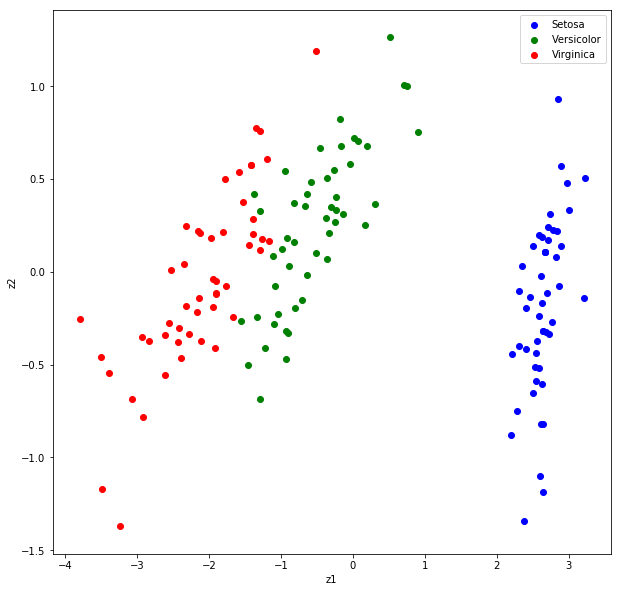

In [17]:
plt.figure()
plt.scatter(Z[y==0, 0], Z[y==0, 1], c='b', label='Setosa')
plt.scatter(Z[y==1, 0], Z[y==1, 1], c='g', label='Versicolor')
plt.scatter(Z[y==2, 0], Z[y==2, 1], c='r', label='Virginica')

plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()

You may have noticed that the z1 dimension (which is our dimension 0 using python 0 based indexing) is
flipped in this figure.  As mentioned in the figures, PCA can return z or the -z of a vector.  Thus, to
get exactly the same figure as we had before, we just need to negate our z vector for the first dimension.

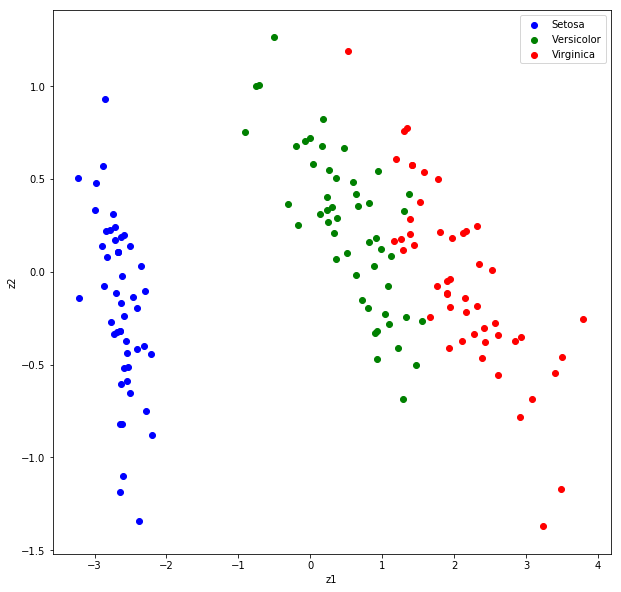

In [18]:
plt.figure()
plt.scatter(-Z[y==0, 0], Z[y==0, 1], c='b', label='Setosa')
plt.scatter(-Z[y==1, 0], Z[y==1, 1], c='g', label='Versicolor')
plt.scatter(-Z[y==2, 0], Z[y==2, 1], c='r', label='Virginica')

plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()

If you look closely at this figure and compare it to the figure produced by using the `scikit-learn`
implementation of PCA, you should see that we got exactly the same result.

# Video W8 10: Choosing the Number of Principal Components

[YouTube Video Link](https://www.youtube.com/watch?v=qqK-8HZjwTo&index=86&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)


As shown in this video, we can use the S matrix from the singular value decomposition to see how much
variance each of the new dimensions discovered by the PCA explains.  I didn't mention it above, but we
can get the S matrix that `scikit-learn` calculates, as well as the ratio of the variance explained
by each of the Z dimensions, like this:

In [19]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[ 4.19667516  0.24062861]
[ 0.92461621  0.05301557]


The explained variance is basically the S matrix from the SVD:

In [20]:
print(S)

[ 4.19667516  0.24062861  0.07800042  0.02352514]


The variance ratio is simply obtained by dividing each variance measure by the total sum of the variance
measures.  

In [21]:
print(S / np.sum(S))

[ 0.92461621  0.05301557  0.01718514  0.00518309]


As discussed in this video, the ratio of the variances in PCA can be interpreted as the amount of
information each dimension holds.  In the case of the iris data set PCA, the first dimension explains
92.5% of the variance of the data, and the second dimension another 5.3%, for a total of almost 98%
of the variance represented by the first 2 dimensions.  Another way that I think of these measures,
the first 2 dimensions of our PCA actually only introduce about 2% of projection error when projecting
the original 4 dimensional data onto the discovered 2 principle component dimensions.

Sometimes you will see people plot the variance ratios.  This isn't too useful for our iris data with
only 4 dimensions total, but when you have a large number of dimensions, it can visually let you
know which dimensions are important, and which add little and mostly represent redundant information
or noise in the data.

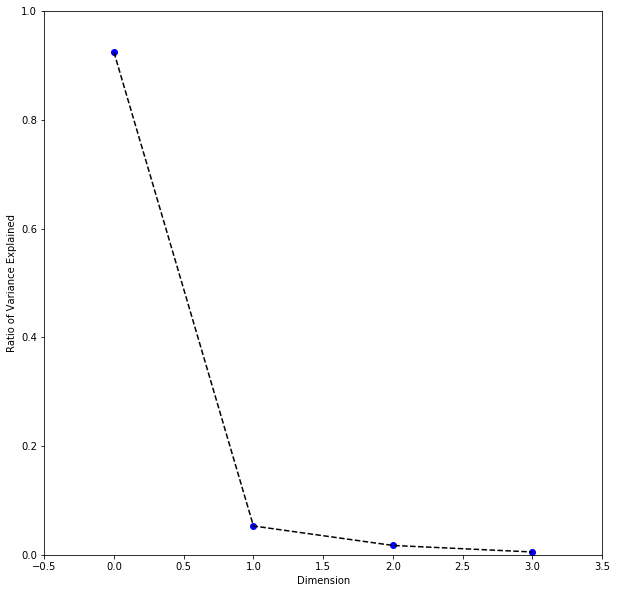

In [22]:
plt.plot(range(4), S/np.sum(S), 'bo')
plt.plot(range(4), S/np.sum(S), 'k--')
plt.axis([-0.5, 3.5, 0.0, 1.0])
plt.xlabel('Dimension')
plt.ylabel('Ratio of Variance Explained')

# Video W8 11: Reconstruction from Compressed Representation

[YouTube Video Link](https://www.youtube.com/watch?v=ATeoRX1GKVE&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=87)


# Video W8 12: Advice for Applying PCA

[YouTube Video Link](https://www.youtube.com/watch?v=QitS8I_Thd8&index=88&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)
